In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Deep learning/deep_learning')
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1JCIWhI2EEnh4FhnlYt0fPfvauIBPufyL/deep_learning'

In [4]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tempfile import TemporaryDirectory
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from datetime import datetime
from timeit import default_timer as timer

cudnn.benchmark = True
plt.ion()   # interactive mode

#loading models

import torchvision.models as models


In [5]:
#activating CUDA
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Loading UCMerced data

In [ ]:
# !unzip './data/transfer_6394502_files_0a0e2750/UCMerced.zip'

In [ ]:
!ls

 data
 DeepLearning_TransferLearning_RockClassification.ipynb
 DeepLearning_TransferLearning_UCMerced.ipynb
 EuroSAT
' LEILA_DeepLearning_Fine_tuning.ipynb'
 LEILA_DeepLearning_TransferLearning_Satellite.ipynb
 models
 UCMerced


In [16]:


# actual path where the dataset is stored
data_dir = './UCMerced/'

# Define the transformations for the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))#All pre-trained models expect input images normalized in the same way
])

# Load training dataset
train_dataset = datasets.ImageFolder(root=data_dir + '/train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load validation dataset
val_dataset = datasets.ImageFolder(root=data_dir + '/val', transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load test dataset
test_dataset = datasets.ImageFolder(root=data_dir + '/test', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)




In [49]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 1050
    Root location: ./UCMerced//train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
           )

In [17]:
# Visualizing the data
from torchvision.utils import make_grid

def show_images(img):
    #img = (img - img.min())/(img.max()-img.min())
    npimg = img.numpy()
    plt.figure(figsize=(8*4,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()



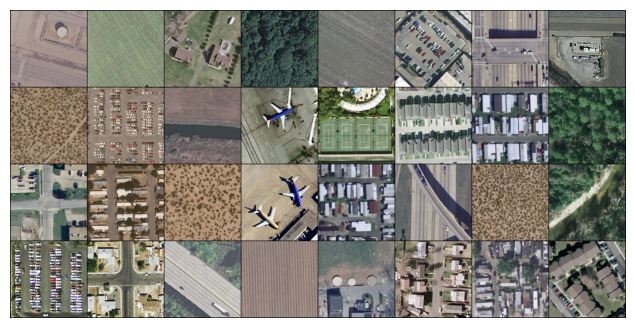

In [11]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
show_images(make_grid(images))

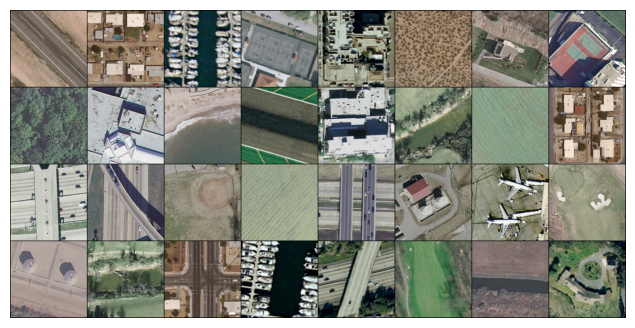

In [ ]:
images, labels = next(dataiter)
show_images(make_grid(images))

# Build a model from scratch

Using LeNet architecture

In [35]:
class LeNet5(nn.Module):
  """
  creates/replicates a LaNet architecture(has 5 layers, 3 convolutional and 2 fully connected layers)

  Args:
  n_channels: An integer that takes the number of bands
  n_classes: An integer that takes the number of classes
  """
  def __init__(self, n_channels, n_classes):
        super(LeNet5, self).__init__()
        #-- convolutional layers
        self.conv1 = nn.Conv2d(n_channels, 6, 5) #first convolutional with 6 kernels of size 5*5
        self.conv2 = nn.Conv2d(6, 16, 5)  #16 filters of size 5*5
        self.conv3 = nn.Conv2d(16, 120, 5) #last convolutional layer with 120 5*5 kernels

        #-- fully connected layers
        self.fc1 = nn.Linear(120*28*28, 84)#first fully connected layer takes input of 120 units and returns 84
        self.fc2 = nn.Linear(84, n_classes) #last dense layer which outputs the number of classes

  def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2) #1st pooling layer with 6 kernels of size 2*2
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) #2nd pooling layer but this time with 16 kernels
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits


In [6]:
#optimization loop
#Each epoch consists of two main parts:

#The Train Loop - iterate over the training dataset and try to converge to optimal parameters.
def train_epoch(model, optimizer, loss_func, dataloader, device):
  model.train()  # the model is in training mode
  train_correct = 0
  train_loss = []
  for x_train_batch, y_train_batch in dataloader:
    x_train_batch = x_train_batch.to(device)
    y_train_batch = y_train_batch.to(device)

    # forward pass
    y_hat = model(x_train_batch)

    loss = loss_func(y_hat, y_train_batch) # compute the loss
    loss.backward() # obtain the gradients with respect to the loss
    optimizer.step() # perform one step of gradient descent
    optimizer.zero_grad() # reset the gradients to 0
    y_hat_class = torch.argmax(y_hat.detach().cpu(), axis=1) # we assign an appropriate label based on the network's prediction
    train_correct += torch.sum(y_hat_class==y_train_batch.cpu())
    train_loss.append(loss.item()/len(x_train_batch))

  train_accuracy = train_correct/len(dataloader.dataset)
  return train_loss, train_accuracy


#The Validation Loop - iterate over the validation dataset to check if model performance is improving.
#similar to the training one, with the difference being the lack of the actual learning step (the backward pass).
def val_epoch(model, loss_func, dataloader, device):
  model.eval()  #the model is in evaluation mode
  tmp_val_loss = 0
  val_correct = 0
  with torch.no_grad():
    for x_val_batch, y_val_batch in dataloader:
      x_val_batch = x_val_batch.to(device)
      y_val_batch = y_val_batch.to(device)
      y_val_hat = model(x_val_batch) # forward pass
      tmp_val_loss += lossF(y_val_hat, y_val_batch).item() # compute the loss
      y_val_hat_class = torch.argmax(y_val_hat.detach().cpu(), axis=1) # we assign an appropriate label based on the network's prediction
      val_correct += torch.sum(y_val_hat_class==y_val_batch.cpu())
  val_loss = tmp_val_loss/len(dataloader.dataset) # compute the average loss
  val_accuracy = val_correct/len(dataloader.dataset)

  return val_loss, val_accuracy


combine them within the training loop

In [7]:
import time
from tqdm.auto import tqdm
def training_loop(model, optimizer, loss_func, train_loader, valid_loader, epochs, device):
    '''
    Function defining the entire training loop
    '''

    train_loss = []  # where we keep track of the training loss
    train_accuracy = []  # where we keep track of the training accuracy of the model
    val_loss = []  # where we keep track of the validation loss
    val_accuracy = []  # where we keep track of the validation accuracy of the model

    # loop through each training and validation steps for a number of epochs
    for e in tqdm(range(epochs)):
        #start_time = time.time()
        epoch_train_loss, epoch_train_accuracy = train_epoch(model, optimizer, loss_func, train_loader, device)
        epoch_val_loss, epoch_val_accuracy = val_epoch(model, loss_func, valid_loader, device)

        #end_time = time.time()
        #epoch_time = end_time - start_time
        #print(f'Epoch {e} took {epoch_time} seconds')
        print(f"Epoch: {e} | Train loss: {np.mean(epoch_train_loss):.4f} | Train acc: {epoch_train_accuracy:.4f} | Test loss: {epoch_val_loss:.4f} | Test acc: {epoch_val_accuracy:.4f}")

        train_loss.append(np.mean(epoch_train_loss))
        train_accuracy.append(epoch_train_accuracy)
        val_loss.append(epoch_val_loss)
        val_accuracy.append(epoch_val_accuracy)

    # plot the loss and accuracy
    results = {
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    }

    return results




To visualize the loss and accuracy

In [8]:
def plot_loss_curves(results):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["val_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_accuracy"]
  test_accuracy = results["val_accuracy"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

In [ ]:

# # Function to visualize the training and validation loss as well as training and validation accuracy
# def visualize_training(training_results):
#       # Plotting
#     plt.figure(figsize=(13, 5))
#     plt.subplot(1, 2, 1)
#     plt.title('Training and Validation Loss')
#     plt.plot(training_results['train_loss'], label="train")
#     plt.plot(training_results['val_loss'], label="val")
#     plt.xlabel('Iterations')
#     plt.ylabel('Cross Entropy Loss')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.title('Training and Validation Accuracy')
#     plt.plot(training_results['train_accuracy'], label="train")
#     plt.plot(training_results['val_accuracy'], label="val")
#     plt.xlabel('Iterations')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     plt.show()



### To save the model

In [9]:
from pathlib import Path
model_dir='./models/'
def save_model(model,target_dir,model_name):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

To visualize parameters

In [10]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")

In [13]:
#create the model
model5 = LeNet5(3, 21).to(device)


In [14]:
# Initialize the loss function and optimizer
lossF = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model5.parameters(),lr=0.01)

In [18]:
#train the model
start_time = timer()
epochs=20
model5=training_loop(model5,optimizer=optimizer,loss_func=lossF,train_loader=train_loader,valid_loader=val_loader,epochs=epochs,device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 0 | Train loss: 0.0950 | Train acc: 0.0657 | Test loss: 0.0896 | Test acc: 0.1032
Epoch: 1 | Train loss: 0.0840 | Train acc: 0.1838 | Test loss: 0.0806 | Test acc: 0.1968
Epoch: 2 | Train loss: 0.0707 | Train acc: 0.3057 | Test loss: 0.0734 | Test acc: 0.3016
Epoch: 3 | Train loss: 0.0557 | Train acc: 0.4476 | Test loss: 0.0746 | Test acc: 0.2984
Epoch: 4 | Train loss: 0.0436 | Train acc: 0.5667 | Test loss: 0.0643 | Test acc: 0.4063
Epoch: 5 | Train loss: 0.0290 | Train acc: 0.7210 | Test loss: 0.0736 | Test acc: 0.3841
Epoch: 6 | Train loss: 0.0192 | Train acc: 0.8238 | Test loss: 0.0901 | Test acc: 0.4667
Epoch: 7 | Train loss: 0.0120 | Train acc: 0.8933 | Test loss: 0.0879 | Test acc: 0.4349
Epoch: 8 | Train loss: 0.0084 | Train acc: 0.9276 | Test loss: 0.0943 | Test acc: 0.4222
Epoch: 9 | Train loss: 0.0056 | Train acc: 0.9514 | Test loss: 0.1024 | Test acc: 0.4730
Epoch: 10 | Train loss: 0.0074 | Train acc: 0.9371 | Test loss: 0.1198 | Test acc: 0.4556
Epoch: 11 | Train lo

In [ ]:
#Save model

save_model(model5,target_dir=model_dir,model_name='LeNet1.pt')

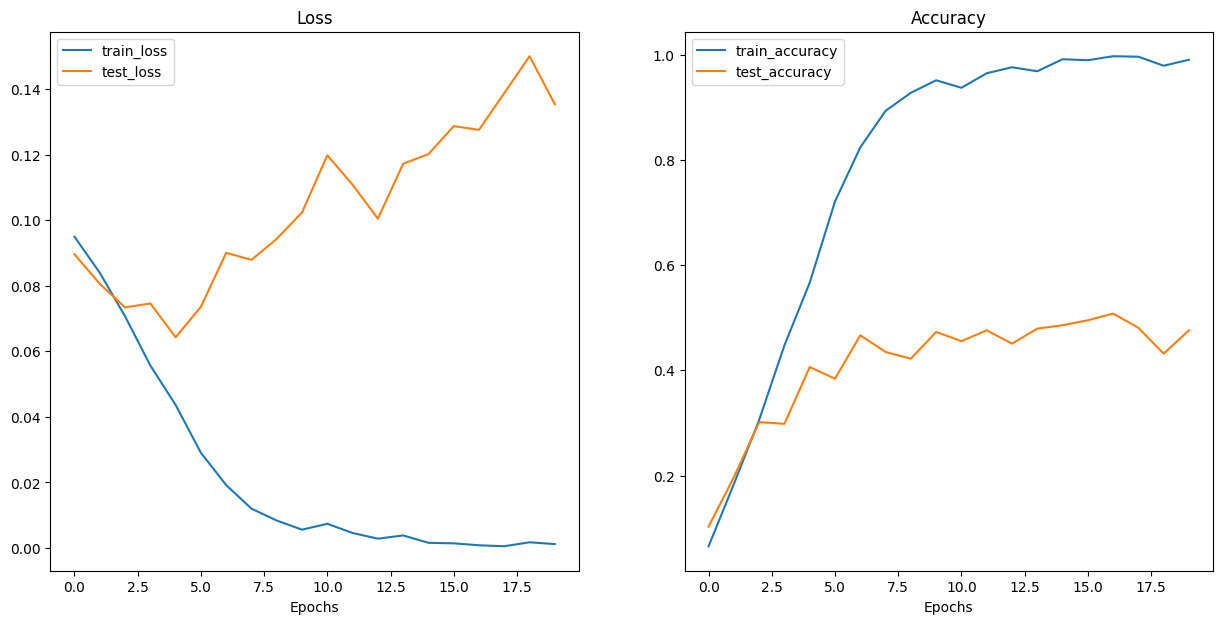

In [20]:
plot_loss_curves(model5)

In [ ]:
val_epoch(model5,lossF,test_loader,device=device)

# Transfer learning
Fine tuning : Instead of random initialization, we initialize the network with a pretrained network. Rest of the training looks as usual.

Feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [22]:
dataloaders={'train':train_loader,'val':val_loader,'test':test_loader}
dataset_sizes={'train':len(train_dataset),'val':len(val_dataset),'test':len(test_dataset)}
class_names=train_dataset.classes

In [21]:
#@title Defining Functions

def show_images(img):
    #img = (img - img.min())/(img.max()-img.min())
    npimg = img.numpy()
    plt.figure(figsize=(8*4,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


import time
from tempfile import TemporaryDirectory
def train_model(model,criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            epoch_start_time = time.time()
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
            epoch_end_time = time.time()  # Record the end time of the epoch
            epoch_time_elapsed = epoch_end_time - epoch_start_time
            print(f'Epoch {epoch} took {epoch_time_elapsed // 60:.0f}m {epoch_time_elapsed % 60:.0f}s')

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model



def test_model(model, criterion, dataloader, device='cuda'):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(dataloader.dataset)
    accuracy = running_corrects.double() / len(dataloader.dataset)

    print(f'Test Loss: {total_loss:.4f} Acc: {accuracy:.4f}')
    return total_loss, accuracy

In [23]:
# def visualize_model(model, num_images=6):
#     was_training = model.training
#     model.eval()
#     images_so_far = 0
#     fig = plt.figure()

#     with torch.no_grad():
#         for i, (inputs, labels) in enumerate(dataloaders['val']):
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)

#             for j in range(inputs.size()[0]):
#                 images_so_far += 1
#                 ax = plt.subplot(num_images//2, 2, images_so_far)
#                 ax.axis('off')
#                 ax.set_title(f'predicted: {class_names[preds[j]]}')
#                 plt.imshow(inputs.cpu().data[j])

#                 if images_so_far == num_images:
#                     model.train(mode=was_training)
#                     return
#         model.train(mode=was_training)

### Fine tuning SqueezeNet
Load your choice of pre-trained network and reshape the classification layer.

For SqueezeNet or other all-convolutional networks, the classification layer will be convolutional (nn.Conv2d). To change the output features you can update the 'out_channels' attribute of the nn.Conv2d module, or replace it

In [14]:
#adopted from https://github.com/culv/SqueezeTune
model_SqueezeNet= models.squeezenet1_1(weights='IMAGENET1K_V1') #loaded the weight pre-defined
num_classes=len(class_names)
#model_SqueezeNet.classifier[1].out_channels = num_classes

# Or alternatively...
in_chans = model_SqueezeNet.classifier[1].in_channels
k = model_SqueezeNet.classifier[1].kernel_size
s = model_SqueezeNet.classifier[1].stride
model_SqueezeNet.classifier[1] = nn.Conv2d(in_chans, num_classes, kernel_size=k, stride=s)

# print the architecture of your network to get an insight on the types of layers and what needs to be changed.
print(model_SqueezeNet.modules)




<bound method Module.modules of SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplac

In [15]:
# Freeze all parameters in the network
for p in model_SqueezeNet.parameters():
    p.requires_grad = False

# Make classification layer trainable
for p in model_SqueezeNet.classifier.parameters():
    p.requires_grad = True

# If you want to make last layer of feature generator trainable. Similarly for the last two,
# or three layers you would use the slice [-2:-1] or [-3:-1]
for p in model_SqueezeNet.features[-1].parameters():
    p.requires_grad = True

In [16]:
model_SqueezeNet=model_SqueezeNet.to(device)
criterion = nn.CrossEntropyLoss()

# algorithm to be used to update the model's parameters based on gradients computed during backpropagation eg ADAM,SGD,RMSprop (Choice will impact training and performance)
#learning rate hyperparameter determines step size at each iteration during optimization
#momentum (in SGD) to accelerate convergence and escpae local minima(https://rumn.medium.com/part-1-ultimate-guide-to-fine-tuning-in-pytorch-pre-trained-model-and-its-configuration-8990194b71e)
optimizer_ft = optim.SGD(model_SqueezeNet.parameters(), lr=0.001, momentum=0.9)

# Weight Decay/L2 regularization(specific to SGD) by a factor of 0.1 every 7 epochs(prevent overfitting)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [18]:
#training
epochs=20
model_ft = train_model(model_SqueezeNet, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=epochs)

Epoch 0/19
----------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


train Loss: 2.4555 Acc: 0.2705
val Loss: 1.5172 Acc: 0.5000
Epoch 0 took 7m 7s

Epoch 1/19
----------
train Loss: 1.0977 Acc: 0.6371
val Loss: 0.8295 Acc: 0.7381
Epoch 1 took 0m 7s

Epoch 2/19
----------
train Loss: 0.6722 Acc: 0.7924
val Loss: 0.8041 Acc: 0.7333
Epoch 2 took 0m 7s

Epoch 3/19
----------
train Loss: 0.5437 Acc: 0.8219
val Loss: 0.6425 Acc: 0.7952
Epoch 3 took 0m 7s

Epoch 4/19
----------
train Loss: 0.3976 Acc: 0.8686
val Loss: 0.5129 Acc: 0.8238
Epoch 4 took 0m 7s

Epoch 5/19
----------
train Loss: 0.3314 Acc: 0.8895
val Loss: 0.4887 Acc: 0.8302
Epoch 5 took 0m 7s

Epoch 6/19
----------
train Loss: 0.2823 Acc: 0.9076
val Loss: 0.5303 Acc: 0.8317
Epoch 6 took 0m 7s

Epoch 7/19
----------
train Loss: 0.2177 Acc: 0.9333
val Loss: 0.3842 Acc: 0.8635
Epoch 7 took 0m 9s

Epoch 8/19
----------
train Loss: 0.1800 Acc: 0.9629
val Loss: 0.3954 Acc: 0.8651
Epoch 8 took 0m 7s

Epoch 9/19
----------
train Loss: 0.1687 Acc: 0.9648
val Loss: 0.3816 Acc: 0.8651
Epoch 9 took 0m 7s

Ep

In [19]:
#test
test_model(model_SqueezeNet, criterion, test_loader, device='cuda')

Test Loss: 0.3662 Acc: 0.8810


(0.36618256795974, tensor(0.8810, device='cuda:0', dtype=torch.float64))

In [31]:
count_parameters(model_SqueezeNet)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|  features.12.squeeze.weight  |   32768    |
|   features.12.squeeze.bias   |     64     |
| features.12.expand1x1.weight |   16384    |
|  features.12.expand1x1.bias  |    256     |
| features.12.expand3x3.weight |   147456   |
|  features.12.expand3x3.bias  |    256     |
|     classifier.1.weight      |   10752    |
|      classifier.1.bias       |     21     |
+------------------------------+------------+
Total Trainable Params: 207957


In [25]:
save_model(model_SqueezeNet,model_dir,"model_SqueezeNet.pt")

[INFO] Saving model to: models/model_SqueezeNet.pt


### Fine tuning ResNet
For most architectures, like ResNet and VGGNet, the classification layer is fully-connected (nn.Linear)which can be reshaped by changing the 'out_features' attribute of the nn.Linear module or replacing it entirely

In [26]:
model_Resnet=models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_Resnet.fc.in_features

# Here the size of each output sample is set to the number of classes
model_Resnet.fc = nn.Linear(num_ftrs,len(class_names))

#or alternatively
#num_classes=len(class_names)
#model_SqueezeNet.fc.out_features=num_classes#

model_Resnet=model_Resnet.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_Resnet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


train and evaluate the network

In [27]:
model_Resnet=train_model(model_Resnet,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=epochs)

Epoch 0/19
----------
train Loss: 2.6196 Acc: 0.2752
val Loss: 1.8215 Acc: 0.6413
Epoch 0 took 0m 15s

Epoch 1/19
----------
train Loss: 1.2314 Acc: 0.8162
val Loss: 0.8978 Acc: 0.8429
Epoch 1 took 0m 10s

Epoch 2/19
----------
train Loss: 0.6621 Acc: 0.9114
val Loss: 0.5939 Acc: 0.8746
Epoch 2 took 0m 10s

Epoch 3/19
----------
train Loss: 0.4124 Acc: 0.9514
val Loss: 0.4349 Acc: 0.9048
Epoch 3 took 0m 10s

Epoch 4/19
----------
train Loss: 0.2740 Acc: 0.9743
val Loss: 0.3456 Acc: 0.9317
Epoch 4 took 0m 10s

Epoch 5/19
----------
train Loss: 0.1898 Acc: 0.9838
val Loss: 0.2924 Acc: 0.9365
Epoch 5 took 0m 10s

Epoch 6/19
----------
train Loss: 0.1486 Acc: 0.9924
val Loss: 0.2559 Acc: 0.9444
Epoch 6 took 0m 10s

Epoch 7/19
----------
train Loss: 0.1224 Acc: 0.9952
val Loss: 0.2572 Acc: 0.9460
Epoch 7 took 0m 10s

Epoch 8/19
----------
train Loss: 0.1185 Acc: 0.9962
val Loss: 0.2494 Acc: 0.9492
Epoch 8 took 0m 10s

Epoch 9/19
----------
train Loss: 0.1096 Acc: 0.9952
val Loss: 0.2480 Acc

test model

In [28]:
test_model(model_Resnet,criterion,test_loader,device='cuda')

Test Loss: 0.2508 Acc: 0.9429


(0.2507968471163795, tensor(0.9429, device='cuda:0', dtype=torch.float64))

In [32]:

count_parameters(model_Resnet)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |   36864    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.1.conv1.weight     |   36864    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |   36864    |
|     layer1.1.bn2.weight      |     64     |
|      layer1.1.bn2.bias       |     64     |
|    layer2.0.conv1.weight     |   73728    |
|     layer2.0.bn1.weight      |    128     |
|      layer2.0.bn1.bias       |    128     |
|    layer2.0.conv2.weight     |  

In [33]:
save_model(model_Resnet,model_dir,"model_Resnet.pt")

[INFO] Saving model to: models/model_Resnet.pt


### SqueezeNet as a Feature extractor

The last fully connected layer is removed then the rest of the network is used as a feature extractor for our dataset. The extracted features are run through a new classifier which is trained from scratch.

To freeze the parameters, we set require_grad=False

In [34]:
model_squeeze_fe = models.squeezenet1_1(weights='IMAGENET1K_V1')
for param in model_squeeze_fe.parameters():
    param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default
model_squeeze_fe.classifier[1]=nn.Conv2d(512,21,kernel_size=(1,1))
model_squeeze_fe.num_classes=21

model_squeeze_fe = model_squeeze_fe.to(device)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_squeeze_fe.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [35]:
#training
model_squeeze_fe = train_model(model_squeeze_fe, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 2.4408 Acc: 0.2981
val Loss: 1.5321 Acc: 0.5460
Epoch 0 took 0m 7s

Epoch 1/19
----------
train Loss: 1.1084 Acc: 0.6667
val Loss: 0.8876 Acc: 0.7111
Epoch 1 took 0m 7s

Epoch 2/19
----------
train Loss: 0.7193 Acc: 0.7819
val Loss: 0.6955 Acc: 0.7698
Epoch 2 took 0m 7s

Epoch 3/19
----------
train Loss: 0.5709 Acc: 0.8333
val Loss: 0.6183 Acc: 0.7968
Epoch 3 took 0m 7s

Epoch 4/19
----------
train Loss: 0.4888 Acc: 0.8571
val Loss: 0.6043 Acc: 0.7921
Epoch 4 took 0m 7s

Epoch 5/19
----------
train Loss: 0.4218 Acc: 0.8876
val Loss: 0.5427 Acc: 0.8238
Epoch 5 took 0m 7s

Epoch 6/19
----------
train Loss: 0.3894 Acc: 0.8905
val Loss: 0.5282 Acc: 0.8286
Epoch 6 took 0m 7s

Epoch 7/19
----------
train Loss: 0.3423 Acc: 0.9143
val Loss: 0.4849 Acc: 0.8508
Epoch 7 took 0m 7s

Epoch 8/19
----------
train Loss: 0.3273 Acc: 0.9305
val Loss: 0.4780 Acc: 0.8603
Epoch 8 took 0m 7s

Epoch 9/19
----------
train Loss: 0.3225 Acc: 0.9295
val Loss: 0.4757 Acc: 0.8603


In [36]:
count_parameters(model_squeeze_fe)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| classifier.1.weight |   10752    |
|  classifier.1.bias  |     21     |
+---------------------+------------+
Total Trainable Params: 10773


In [37]:
#testing
test_model(model_squeeze_fe, criterion, test_loader, device = 'cuda')

Test Loss: 0.4673 Acc: 0.8429


(0.46727963515690396, tensor(0.8429, device='cuda:0', dtype=torch.float64))

In [38]:
save_model(model_squeeze_fe,model_dir,'model_squeeze_fe.pt')

[INFO] Saving model to: models/model_squeeze_fe.pt


### ResNet as a Feature Extractor


In [24]:
model_res_fe = models.resnet18(weights='IMAGENET1K_V1')
for param in model_res_fe.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_res_fe.fc.in_features
model_res_fe.fc = nn.Linear(num_ftrs,2)

model_res_fe = model_res_fe.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_res_fe.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 33.3MB/s]


In [ ]:
#training
model_res_fe = train_model(model_res_fe,criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=20)

In [ ]:
#testing
test_model(model_res_fe, criterion, test_loader, device = 'cuda')